# Калибровка модели неклиентов

Модель неклиентов использует ансамблевый подход, где обобщаются предсказания нескольких моделей. По умолчанию есть MAX_MODLES моделей (lightGBM), каждая из которых обучается на своём объёме данных, состоящего из TRAIN_PERIODS периодов (месяцев), т.е. каждая модель делает предсказание для определенного периода. 

![тренировочная и тестовая выборки](folds.png)

Ансамбль моделей «взвешивается» сигмоидой (логистической регрессией). На выходе модель выдаёт скоры принадлежности к положительному классу (клиент банка).

В такой и подобных задачах возникает т.н. проблема **калибровки** предсказаний – необходимо знать, какова вероятность того, что ответ правильный? Наиболее распространенный подход состоит в следующем: разбить все полученные скоры на группы (бины), обычно это интервалы [0, 0.1], [0.1, 0.2], [0.2, 0.3] … [0.9, 1], вычислить средний скор в каждой и сравнить его с долей положительных объектов в этой группе. Если средний скор в каждой группе совпадает с соответствующей долей положительных объектов, то такой классификатор считают идеально откалиброванным. Калибровку наглядно можно представить в виде калибровочной кривой, где по ОХ откладывается средний скор в каждом бине, по ОY – доля положительных объектов. Идеально откалиброванному классификатору соответствует прямая y=x.


In [1]:
import re, os, sys, datetime, gc, json, copy
import pandas as pd
import numpy as np
import joblib
import lightgbm as lgbm
import config as conf

import sklearn
from sklearn.metrics import (f1_score, roc_auc_score, confusion_matrix,
                             precision_recall_curve)
from sklearn.metrics import (confusion_matrix, precision_recall_curve, fbeta_score,
                            classification_report, brier_score_loss, precision_score)

from sklearn.preprocessing import binarize, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.utils.validation import check_is_fitted
from sklearn.isotonic import IsotonicRegression


from betacal import BetaCalibration

import matplotlib.pyplot as plt

import pickle

import seaborn as sns

from IPython.display import Latex

plt.style.use(['seaborn-darkgrid'])
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print(f'lgb version is {lgbm.__version__}')
print(f'sklearn version is {sklearn.__version__}')

lgb version is 3.2.1
sklearn version is 0.24.1


In [3]:
data_path = '/home/zhernokleev-ga_ca-sbrf-ru/privlechenie/data/MODEL'
model_path = '/home/zhernokleev-ga_ca-sbrf-ru/test&shit/calibration/data/MODEL'

In [4]:
train = joblib.load('{}/train.pkl'.format(data_path))
valid = joblib.load('{}/valid.pkl'.format(data_path))

In [5]:
valid_target = valid[['target']].copy()

DROP_COLS = ['target_days', 'target_res', 'active_flg', 'in_campaign',
             'in_inns', 'in_trans', 'in_basis', 'in_okved', 'in_orgs']
train = train.drop(DROP_COLS, 1, errors='ignore')
valid = valid.drop(DROP_COLS, 1, errors='ignore')
print('Original train size:', train.shape[0])
print('Original pos count:', train['target'].sum())

Original train size: 3943887
Original pos count: 84784


In [7]:
conf.MAX_MODELS = 12

In [8]:
def get_report(true, pred_proba, threshold=None):
    if threshold is None:
        threshold = get_max_threshold_for_f1(true, pred_proba)
    pred_class = binarize(pred_proba.reshape(-1,1), threshold=threshold)
    f1  = f1_score(true, pred_class, average='binary')
    auc = roc_auc_score(true, pred_proba)
    tn, fp, fn, tp = confusion_matrix(true, pred_class).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    report = 'F1:{:.4f}, AUC:{:.4f}, Precision:{:.4f}, Recall:{:.4f}, Scores: [{:.3f} ... {:.3f}] avg: {:.3f} Thresh: {:.3f}' \
        .format(f1, auc, precision, recall, pred_proba.min(), pred_proba.max(), pred_proba.mean(), threshold)
    return report


def get_max_threshold_for_f1(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    max_f1 = 0
    for r, p, t in zip(recall, precision, thresholds):
        if t == y_proba.max():
            break
        if p + r == 0:
            continue
        if (2*p*r)/(p + r) > max_f1:
            max_f1 = (2*p*r)/(p + r)
            max_f1_threshold = t
    return max_f1_threshold


def random_downsampling(df_orig):
    df = df_orig.copy()
    pos_size = df[df.target==1].shape[0]
    neg_size = df[df.target==0].shape[0]
    neg_index = df[df.target==0].index.values
    neg_index_sampled = np.random.choice(neg_index, size=min(neg_size, int(pos_size*(1/conf.MIN_SAMPLING_RATE-1))),
                                         replace=False)
    neg_index_drop = set(neg_index) - set(neg_index_sampled)
    df = df.drop(neg_index_drop, 0)
    return df

def calibration_plot(df, target_col='target', score_col='score', bins=10, quantile=False):
    dfc = df.copy()
    dfc[[score_col]] = MinMaxScaler().fit_transform(dfc[[score_col]])
    if quantile:
        dfc['bin'] = pd.qcut(dfc[score_col], q=bins, retbins=False, labels=None, precision=2)
    else:
        borders = np.linspace(0, 1, bins+1)
        dfc['bin'] = pd.cut(dfc[score_col], bins=borders, retbins=False, labels=None, precision=2)
    # dfc['pos_frac'] = dfc.groupby('bin')[target_col].transform('sum') / (dfc[target_col] == 1).sum()
    dfc['pos_frac'] = dfc.groupby('bin')[target_col].transform('mean')
    dfc['avg_score'] = dfc.groupby('bin')[score_col].transform('mean')
    dfc['sample_frac'] = dfc.groupby('bin')[score_col].transform('count') / dfc.shape[0]
    qbin_df = dfc.reset_index(drop=True).drop([target_col, score_col], 1).drop_duplicates(subset=['bin']).set_index('bin').sort_index()
    qbin_df = qbin_df.dropna()
    plt.bar(height=qbin_df.avg_score, x=range(bins), label='avg_score', alpha=0.8)
    plt.bar(height=qbin_df.pos_frac, x=range(bins), label='pos_frac', alpha=0.6)
    plt.bar(height=qbin_df.sample_frac, x=range(bins), label='sample_frac', width=0.15, color='gray')
    plt.xticks(ticks=range(bins), labels=qbin_df.index, rotation=90)
    plt.legend(loc='best')
    if quantile:
        plt.title('Диаграмма калибровки скоров модели (бины по высоте)')
    else:
        plt.title('Диаграмма калибровки скоров модели (бины по ширине)')
    plt.show()
    return qbin_df

### параметры LGBM

In [10]:
lgbm_params =  {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'seed': 100,
        'num_threads': 8,
        'boosting_type': 'goss',
        'sigmoid': 1.0,
    }

hyper_params = {
    'max_depth':                 -1,
    'learning_rate':             0.03,
    'num_leaves':                512,
    'min_data_in_leaf':          250,
    'feature_fraction':          0.95,
    'max_bin':                   20,
    'min_sum_hessian_in_leaf':   100,
    'is_unbalance':              True,
    'min_gain_to_split':         0,
    'lambda_l1':                 10,
    'lambda_l2':                 1000,
}

lgbm_params = {**lgbm_params, **hyper_params}

params = dict(
    early_stopping_rounds = 100,
    verbose_eval = None,
    rounds = 3000,
    meta_cls = conf.META_MODELING,
    sampling = conf.DATA_SAMPLING,
    importance_method = conf.IMPORTANCE_METHOD,
)

assert (train.columns.values == valid.columns.values).all()


## Модель без калибровки

In [11]:
def train_folds(X, X_sol, lgbm_params={}, early_stopping_rounds=10,
                verbose_eval=False, rounds=1000, meta_cls=False, sampling=False,
                importance_method='gain', calibration=True):

    X = X.reset_index()
    ts_values = sorted(list(set(X.last_day.values)))
    ts_values = ts_values[len(ts_values)-min(conf.MAX_MODELS+conf.TRAIN_PERIODS, len(ts_values)):]    
    ts_folds = []

    
    for n in range(conf.TRAIN_PERIODS, len(ts_values)):
        ts_folds.append((ts_values[max(0, n-conf.TRAIN_PERIODS):n], ts_values[n]))
    n_folds = len(ts_folds)
    print('Folds: {}'.format(n_folds))
    print(ts_folds)

    X = X.loc[X.last_day.isin(ts_values)].copy()
        
    y_sol = X_sol['target']
    X_sol = X_sol.drop(['target'], 1)

    blend_sol = np.zeros((X_sol.shape[0], n_folds), dtype='float32')

    columns = X.drop(['target', 'inn', 'last_day'], 1, errors='ignore').columns.tolist()
    importances = pd.DataFrame([], index=columns)
    importances.index.name = 'feature'

#     model_path = os.path.abspath('../models/{}'.format(conf.MODEL_NAME))
#     data_path = os.path.abspath('../data/{}'.format(conf.MODEL_NAME))

    models = []
    raw_score = meta_cls
    
    
    fig1, ax1 = plt.subplots()
    ax1.plot([0, 1], [0, 1], 'k:')
    ax1.set_title('Calibration curve')
    
    for i, (train_values, test_value) in enumerate(ts_folds):
        print(test_value, train_values)
        X_train = X.loc[X.last_day.isin(train_values)].copy()
        X_test = X.loc[X.last_day == test_value].copy()
        
        y_train = X_train['target'].copy()
        y_test = X_test['target'].copy()
        
        if sampling:
            X_train = random_downsampling(X_train)
            y_train = X_train['target'].copy()
        
        X_train = X_train.drop(['target'], 1)
        X_test = X_test.drop(['target'], 1)

        X_train = X_train.set_index(['inn', 'last_day'])
        X_test = X_test.set_index(['inn', 'last_day'])

        X_train, y_train = shuffle(X_train, y_train)

        print('FOLD: train: {}, train pos/neg: {}/{}, balance: {:.3f}'
              .format(str(X_train.shape), y_train.values.sum(),
                      y_train.size-y_train.values.sum(), y_train.values.mean()))
        print('FOLD: test: {}, test pos/neg: {}/{}, balance: {:.3f}'
              .format(str(X_test.shape), y_test.values.sum(),
                      y_test.size-y_test.values.sum(), y_test.values.mean()))

        lgbm_train = lgbm.Dataset(X_train, y_train)
        lgbm_test = lgbm.Dataset(X_test, y_test, reference=lgbm_train)

        assert (X_train.shape[1] == X_test.shape[1]) and (X_train.columns == X_test.columns).all()
        assert (X_train.shape[1] == X_sol.shape[1]) and (X_train.columns == X_sol.columns).all()

        model = lgbm.train(lgbm_params,
                           lgbm_train,
                           num_boost_round = rounds,
                           valid_sets = [lgbm_train, lgbm_test],
                           valid_names = ['train', 'valid'],
                           verbose_eval = verbose_eval,
                           early_stopping_rounds = early_stopping_rounds)
#         model = lgbm.LGBMClassifier(**lgbm_params, 
#                                     verbose_eval = verbose_eval).fit(X_train, y_train)


        trees = model.best_iteration
        model_file = '{}/model_cv_{:02d}.txt'.format(model_path, i)
#        model_file = '{}/model_cv_{:02d}.pkl'.format(model_path, i)
        model.save_model(model_file)
#         with open(model_file, 'wb') as mf:
#             pickle.dump(model, mf)
        models.append(model_file)

        train_proba = model.predict(X_train)
        test_proba = model.predict(X_test)
        sol_proba = model.predict(X_sol)

        train_auc = roc_auc_score(y_train, train_proba)
        test_auc = roc_auc_score(y_test, test_proba)
        sol_auc = roc_auc_score(y_sol, sol_proba)

        print('{:2} TRAIN:{:.5f} TEST:{:.5f} SOL:{:.5f} TREES:{:6} min-max:[{:.4f}...{:.4f}] avg:{:.4f}'.format(
                    i, train_auc, test_auc, sol_auc, trees, test_proba.min(), test_proba.max(), test_proba.mean() ))
        
        
        x1, y1 = calibration_curve(y_sol, sol_proba, n_bins=10, normalize=True)
        ax1.plot(y1, x1, label='period {}: {}'.format(i, test_value))
        

#             importances['fold_%d' % i] = model.feature_importances_()
        blend_sol[:,i] = sol_proba
        print('-' * 100)
#             if i == 0: break

    print('-' * 100)
    sol = blend_sol.mean(axis=1)
    ax1.legend()
    
    if meta_cls:
        print('Train meta model')
        if y_sol is not None:
            print('Avg concat:')
            print(get_report(y_sol, sol, threshold=0.5))
            print('-' * 100)

        X = X.set_index(['inn', 'last_day'])
        y = X['target'].copy()
        X = X.drop(['target'], 1)
        blend_train = np.zeros((X.shape[0], len(models)), dtype='float32')
        blend_sol = np.zeros((X_sol.shape[0], len(models)), dtype='float32')
        print('Meta train shapes: {}, {}'.format(str(blend_train.shape), str(blend_sol.shape)))

        for i, model_file in enumerate(models):
            model = lgbm.Booster(model_file=model_file, silent=True)
#             with open(model_file, 'rb') as mf:
#                 model = pickle.load(mf)

            train_proba = model.predict(X)
            blend_train[:, i] = train_proba

            sol_proba = model.predict(X_sol)
            blend_sol[:, i] = sol_proba

        # np.save('{}/train_output_raw.npy'.format(data_path), blend_train)
        # np.save('{}/test_output_raw.npy'.format(data_path), blend_sol)
        # np.save('{}/train_target_raw.npy'.format(data_path), y.values)
        # np.save('{}/test_target_raw.npy'.format(data_path), y_sol)

        lr = LogisticRegression(class_weight='balanced', C=conf.LOGREG_C)
        lr.fit(blend_train, y.values)
        sol = lr.predict_proba(blend_sol)[:,1]
        print(lr.coef_, lr.intercept_)
        
        x, y = calibration_curve(valid_target.target, sol, n_bins=10, normalize=True)
        ax1.plot(y, x, label='meta', color='k')
        ax1.legend()
        ax1.set_title('Без калибровки')
        plt.savefig('without_cal.png')

    return sol #, importances

Folds: 12
[(['2019-10-31', '2019-11-30', '2019-12-31'], '2020-01-31'), (['2019-11-30', '2019-12-31', '2020-01-31'], '2020-02-29'), (['2019-12-31', '2020-01-31', '2020-02-29'], '2020-03-31'), (['2020-01-31', '2020-02-29', '2020-03-31'], '2020-04-30'), (['2020-02-29', '2020-03-31', '2020-04-30'], '2020-05-31'), (['2020-03-31', '2020-04-30', '2020-05-31'], '2020-06-30'), (['2020-04-30', '2020-05-31', '2020-06-30'], '2020-07-31'), (['2020-05-31', '2020-06-30', '2020-07-31'], '2020-08-31'), (['2020-06-30', '2020-07-31', '2020-08-31'], '2020-09-30'), (['2020-07-31', '2020-08-31', '2020-09-30'], '2020-10-31'), (['2020-08-31', '2020-09-30', '2020-10-31'], '2020-11-30'), (['2020-09-30', '2020-10-31', '2020-11-30'], '2020-12-31')]
2020-01-31 ['2019-10-31', '2019-11-30', '2019-12-31']
FOLD: train: (192400, 72), train pos/neg: 19240/173160, balance: 0.100
FOLD: test: (255726, 72), test pos/neg: 6235/249491, balance: 0.024
 0 TRAIN:0.77476 TEST:0.75209 SOL:0.72380 TREES:   408 min-max:[0.0270...0.9

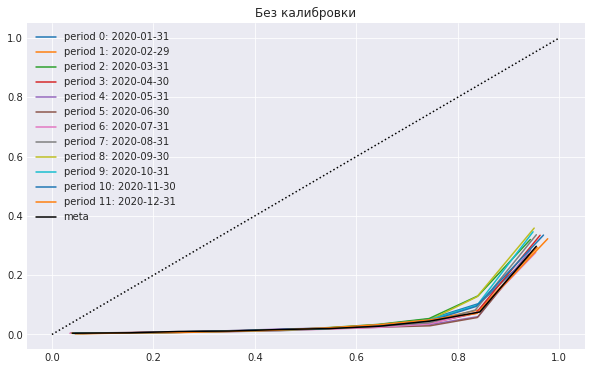

In [12]:
# valids = train_folds(train, valid,
#                                   lgbm_params=lgbm_params,
#                                   **params)

valids = train_folds(train, valid,
                                  lgbm_params=lgbm_params,
                                  **params)


valid_target['score'] = valids
print(get_report(valid_target.target.values, valids, threshold=0.5))

# valid_file = '{}/valids.csv'.format(data_path)
# importances_file = '{}/importances_{}.csv'.format(data_path, conf.IMPORTANCE_METHOD)
# valid_target.to_csv(valid_file)
# importances.to_csv(importances_file)
# print('Validation data file: {}'.format(valid_file))
# print('Importances file: {}'.format(importances_file))

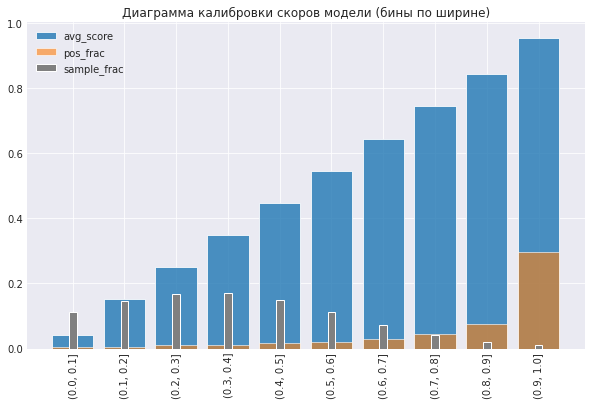

,pos_frac,avg_score,sample_frac
bin,,,
"(0.0, 0.1]",0.004266,0.040132,0.113344
"(0.1, 0.2]",0.005570,0.152718,0.146593
"(0.2, 0.3]",0.010180,0.250423,0.166401
"(0.3, 0.4]",0.011541,0.349563,0.169427
"(0.4, 0.5]",0.016685,0.448236,0.148745
"(0.5, 0.6]",0.019943,0.546622,0.111339
"(0.6, 0.7]",0.027892,0.645617,0.072929
"(0.7, 0.8]",0.045044,0.744896,0.040469
"(0.8, 0.9]",0.075922,0.843506,0.019529


In [13]:
calibration_plot(valid_target, bins=10)

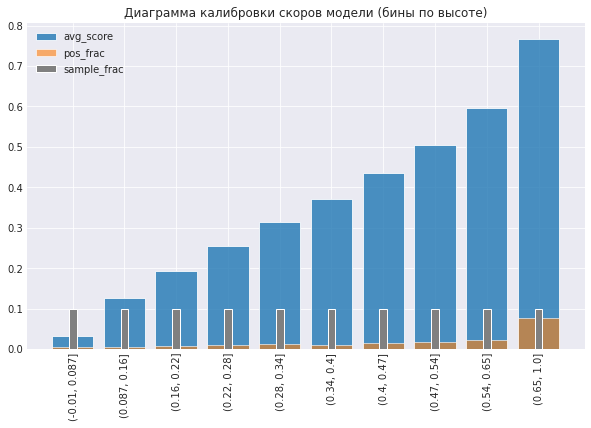

,pos_frac,avg_score,sample_frac
bin,,,
"(-0.01, 0.087]",0.004154,0.032965,0.100000
"(0.087, 0.16]",0.005264,0.127720,0.100000
"(0.16, 0.22]",0.006912,0.193703,0.100000
"(0.22, 0.28]",0.010565,0.254675,0.100000
"(0.28, 0.34]",0.011747,0.313793,0.100000
"(0.34, 0.4]",0.011425,0.372445,0.099997
"(0.4, 0.47]",0.016116,0.434493,0.100000
"(0.47, 0.54]",0.017620,0.504805,0.100000
"(0.54, 0.65]",0.023386,0.595336,0.100000


In [14]:
calibration_plot(valid_target, bins=10, quantile=True)

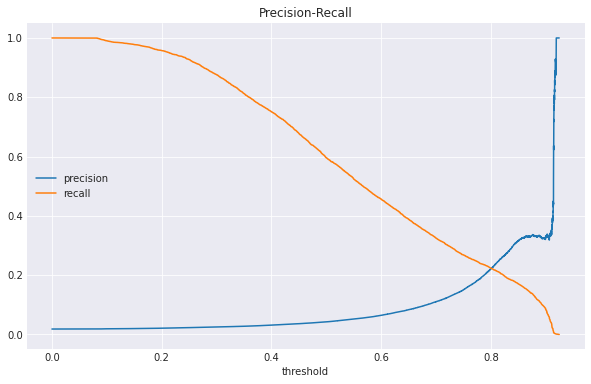

In [15]:
precision, recall, thresholds = precision_recall_curve(valid_target.target.values, valid_target.score.values)
thresholds = np.asarray([0.0] + thresholds.tolist())
#ax[2].figure(figsize=(6, 6))
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
plt.title('Precision-Recall')
plt.xlabel('threshold')
plt.legend(loc='best')
plt.show()

Из графика видно, что модель плохо откалибрована. Решим задачу калибровки. Возможно несколько подходов.

## Калибровка моделей (фолдов) на отложенных данных изотонной регрессией

Изотонная регрессия в нашем случае выступает в качестве неубывающей функции деформации скоров. Изотонная регрессия решает следующую задачу:

$x=y$

**Основная идея** состоит в том, чтобы откалибровать каждую модель на отложенных данных. В таком случае, обобщённая метамодель также будет иметь лучшую калбировку.

![тренировочная, тестовая и калибровочная выборки](folds_calibration.png)

In [28]:
def train_folds_1(X, X_sol, lgbm_params={}, early_stopping_rounds=10,
                verbose_eval=False, rounds=1000, meta_cls=False, sampling=False,
                importance_method='gain'):
    
    calibration = True
    
    X = X.reset_index()
    ts_values = sorted(list(set(X.last_day.values)))
    ts_values1 = copy.deepcopy(ts_values)
    ts_values = ts_values[len(ts_values)-min(conf.MAX_MODELS+conf.TRAIN_PERIODS, len(ts_values)):]
    ts_values_c = ts_values1[max(len(ts_values1)-min(conf.MAX_MODELS+conf.TRAIN_PERIODS, len(ts_values1))-3,0):]
    ts_folds = []
    ts_folds_c = []
    
    for n in range(conf.TRAIN_PERIODS, len(ts_values)):
        ts_folds.append((ts_values[max(0, n-conf.TRAIN_PERIODS):n], ts_values[n]))
    n_folds = len(ts_folds)
    print('Folds: {}'.format(n_folds))
    print(ts_folds)
    
# calibration

    if calibration:
        for n in range(conf.TRAIN_PERIODS, len(ts_values_c)):
            ts_folds_c.append(ts_values_c[max(0, n-conf.TRAIN_PERIODS):n])
        n_folds_c = len(ts_folds_c)
        print('Folds: {}'.format(n_folds_c))
        print(ts_folds_c)

    if calibration:
        X = X.loc[X.last_day.isin(ts_values+ts_values_c)].copy()
    else:
        X = X.loc[X.last_day.isin(ts_values)].copy()
        
    y_sol = X_sol['target']
    X_sol = X_sol.drop(['target'], 1)

    blend_sol = np.zeros((X_sol.shape[0], n_folds), dtype='float32')

    columns = X.drop(['target', 'inn', 'last_day'], 1, errors='ignore').columns.tolist()
    importances = pd.DataFrame([], index=columns)
    importances.index.name = 'feature'

#     model_path = os.path.abspath('../models/{}'.format(conf.MODEL_NAME))
#     data_path = os.path.abspath('../data/{}'.format(conf.MODEL_NAME))

    models = []
    raw_score = meta_cls
    ttrains, ttest = zip(*ts_folds)
    if calibration:
        
        fig1, ax1 = plt.subplots()
        ax1.plot([0, 1], [0, 1], 'k:')
        ax1.set_title('Calibration curve')

        for i, (train_values, test_value, cal_values) in enumerate(zip(ttrains, ttest, ts_folds_c)):
            print(test_value, train_values, cal_values)
            X_train = X.loc[X.last_day.isin(train_values)].copy()
            X_test = X.loc[X.last_day == test_value].copy()
            X_cal = X.loc[X.last_day.isin(cal_values)].copy()
            
            y_train = X_train['target'].copy()
            y_test = X_test['target'].copy()
            y_cal = X_cal['target'].copy()
            
            if sampling:
                X_train = random_downsampling(X_train)
                y_train = X_train['target'].copy()
                X_cal = random_downsampling(X_cal)
                y_cal = X_cal['target'].copy()


            X_train = X_train.drop(['target'], 1)
            X_test = X_test.drop(['target'], 1)
            X_cal = X_cal.drop(['target'], 1)
            
            X_train = X_train.set_index(['inn', 'last_day'])
            X_test = X_test.set_index(['inn', 'last_day'])
            X_cal = X_cal.set_index(['inn', 'last_day'])

            X_train, y_train = shuffle(X_train, y_train)
            X_cal, y_cal = shuffle(X_cal, y_cal)
            
            print('FOLD: train: {}, train pos/neg: {}/{}, balance: {:.3f}'
                  .format(str(X_train.shape), y_train.values.sum(),
                          y_train.size-y_train.values.sum(), y_train.values.mean()))
            print('FOLD: test: {}, test pos/neg: {}/{}, balance: {:.3f}'
                  .format(str(X_test.shape), y_test.values.sum(),
                          y_test.size-y_test.values.sum(), y_test.values.mean()))
            print('FOLD: calibration: {}, test pos/neg: {}/{}, balance: {:.3f}'
                  .format(str(X_cal.shape), y_cal.values.sum(),
                          y_cal.size-y_cal.values.sum(), y_cal.values.mean()))
            
            
            lgbm_train = lgbm.Dataset(X_train, y_train)
            lgbm_test = lgbm.Dataset(X_test, y_test, reference=lgbm_train)

            assert (X_train.shape[1] == X_test.shape[1]) and (X_train.columns == X_test.columns).all()
            assert (X_train.shape[1] == X_sol.shape[1]) and (X_train.columns == X_sol.columns).all()

#             model_b = lgbm.train(lgbm_params,
#                                lgbm_train,
#                                num_boost_round = rounds,
#                                valid_sets = [lgbm_train, lgbm_test],
#                                valid_names = ['train', 'valid'],
#                                verbose_eval = verbose_eval,
#                                early_stopping_rounds = early_stopping_rounds)
            
            model = lgbm.LGBMClassifier(**lgbm_params, 
                                        verbose_eval = verbose_eval, 
                                        early_stopping_rounds = early_stopping_rounds,
                                        n_estimators = rounds
                                       ).fit(X_train, y_train, 
                                             eval_set = [(X_train, y_train), (X_test, y_test)],
                                             eval_names = ['train', 'valid'],
                                             verbose = False)

            trees = model.best_iteration_
#             model_as_str = model_b.model_to_string()
#             model._Booster = model_b
#             model = model.booster_.model_from_string(model_as_str)
            cal_model = CalibratedClassifierCV(base_estimator=model, cv='prefit', method='isotonic')
            cal_model.fit(X_cal, y_cal)
#             cal_model = model  
#             print('trees = {}'.format(trees))
#             model_file = '{}/model_cv_{:02d}.txt'.format(model_path, i)
            model_file = '{}/model_cv_{:02d}.pkl'.format(model_path, i)
#             cal_model.save_model(model_file)
            with open(model_file, 'wb') as mf:
                pickle.dump(cal_model, mf)
            models.append(model_file)

            train_proba = cal_model.predict(X_train) #cal_model.predict(X_train)
            test_proba = cal_model.predict(X_test) #cal_model.predict(X_test)
            sol_proba = cal_model.predict(X_sol) #cal_model.predict(X_sol)
            
            print('TEST: labels_min={}, labels_max={}, calibr_min={}, calibr_max={}'.format(y_test.min(), y_test.max(), test_proba.min(), test_proba.max()))
            
            train_auc = roc_auc_score(y_train, train_proba)
            test_auc = roc_auc_score(y_test, test_proba)
            sol_auc = roc_auc_score(y_sol, sol_proba)

            print('{:2} TRAIN:{:.5f} TEST:{:.5f} SOL:{:.5f} TREES:{} min-max:[{:.4f}...{:.4f}] avg:{:.4f}'.format(
                    i, train_auc, test_auc, sol_auc, trees, test_proba.min(), test_proba.max(), test_proba.mean() ))

            x1, y1 = calibration_curve(y_sol, sol_proba, n_bins=10, normalize=True)
            ax1.plot(y1, x1, label='period {}: {}'.format(i, test_value))


#             importances['fold_%d' % i] = model.feature_importances_()
            blend_sol[:,i] = sol_proba
            print('-' * 100)
#             if i == 0: break

        print('-' * 100)
        sol = blend_sol.mean(axis=1)

        if meta_cls:
            print('Train meta model')
            if y_sol is not None:
                print('Avg concat:')
                print(get_report(y_sol, sol, threshold=0.5))
                print('-' * 100)

            X = X.set_index(['inn', 'last_day'])
            y = X['target'].copy()
            X = X.drop(['target'], 1)
            blend_train = np.zeros((X.shape[0], len(models)), dtype='float32')
            blend_sol = np.zeros((X_sol.shape[0], len(models)), dtype='float32')
            print('Meta train shapes: {}, {}'.format(str(blend_train.shape), str(blend_sol.shape)))

            for i, model_file in enumerate(models):
#                 model = lgbm.Booster(model_file=model_file, silent=True)
                with open(model_file, 'rb') as mf:
                    model = pickle.load(mf)

                train_proba = model.predict(X)
                blend_train[:, i] = train_proba

                sol_proba = model.predict(X_sol)
                blend_sol[:, i] = sol_proba

            # np.save('{}/train_output_raw.npy'.format(data_path), blend_train)
            # np.save('{}/test_output_raw.npy'.format(data_path), blend_sol)
            # np.save('{}/train_target_raw.npy'.format(data_path), y.values)
            # np.save('{}/test_target_raw.npy'.format(data_path), y_sol)

            lr = LogisticRegression(class_weight='balanced', C=conf.LOGREG_C)
            lr.fit(blend_train, y.values)
            sol = lr.predict_proba(blend_sol)[:,1]
            print(lr.coef_, lr.intercept_)
            
            x, y = calibration_curve(valid_target.target, sol, n_bins=10, normalize=True)
            ax1.plot(y, x, label='meta', color='k')
            ax1.legend()
            ax1.set_title('Калибровка каждого фолда на отложенных данных изотонической регрессией')
            plt.savefig('folds_cal_iso.png')

        return sol #, importances

Folds: 12
[(['2019-10-31', '2019-11-30', '2019-12-31'], '2020-01-31'), (['2019-11-30', '2019-12-31', '2020-01-31'], '2020-02-29'), (['2019-12-31', '2020-01-31', '2020-02-29'], '2020-03-31'), (['2020-01-31', '2020-02-29', '2020-03-31'], '2020-04-30'), (['2020-02-29', '2020-03-31', '2020-04-30'], '2020-05-31'), (['2020-03-31', '2020-04-30', '2020-05-31'], '2020-06-30'), (['2020-04-30', '2020-05-31', '2020-06-30'], '2020-07-31'), (['2020-05-31', '2020-06-30', '2020-07-31'], '2020-08-31'), (['2020-06-30', '2020-07-31', '2020-08-31'], '2020-09-30'), (['2020-07-31', '2020-08-31', '2020-09-30'], '2020-10-31'), (['2020-08-31', '2020-09-30', '2020-10-31'], '2020-11-30'), (['2020-09-30', '2020-10-31', '2020-11-30'], '2020-12-31')]
Folds: 12
[['2019-10-31', '2019-11-30', '2019-12-31'], ['2019-11-30', '2019-12-31', '2020-01-31'], ['2019-12-31', '2020-01-31', '2020-02-29'], ['2020-01-31', '2020-02-29', '2020-03-31'], ['2020-02-29', '2020-03-31', '2020-04-30'], ['2020-03-31', '2020-04-30', '2020-05-

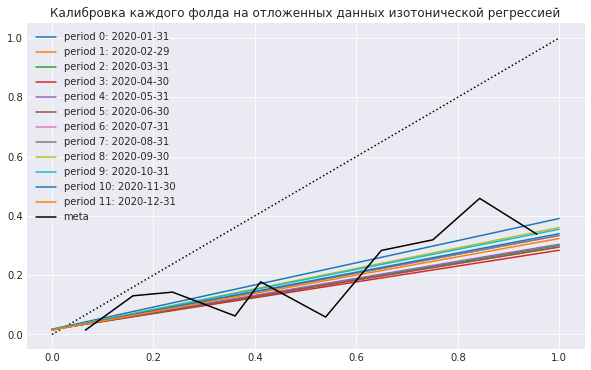

In [29]:
valids = train_folds_1(train, valid,
                                  lgbm_params=lgbm_params,
                                  **params)


valid_target['score'] = valids
print(get_report(valid_target.target.values, valids, threshold=0.5))

# valid_file = '{}/valids.csv'.format(data_path)
# importances_file = '{}/importances_{}.csv'.format(data_path, conf.IMPORTANCE_METHOD)
# valid_target.to_csv(valid_file)
# importances.to_csv(importances_file)
# print('Validation data file: {}'.format(valid_file))
# print('Importances file: {}'.format(importances_file))

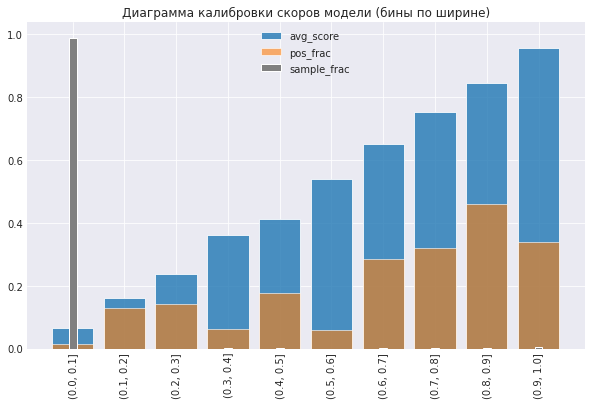

,pos_frac,avg_score,sample_frac
bin,,,
"(0.0, 0.1]",0.014841,0.066093,0.987419
"(0.1, 0.2]",0.130435,0.159739,0.000082
"(0.2, 0.3]",0.142857,0.237737,0.000075
"(0.3, 0.4]",0.062500,0.361044,0.001261
"(0.4, 0.5]",0.177570,0.411387,0.001533
"(0.5, 0.6]",0.058824,0.539510,0.000061
"(0.6, 0.7]",0.283410,0.649410,0.001554
"(0.7, 0.8]",0.319249,0.750987,0.000763
"(0.8, 0.9]",0.459103,0.843218,0.001357


In [30]:
calibration_plot(valid_target, bins=10)

In [31]:
calibration_plot(valid_target, bins=10, quantile=True)

ValueError: Bin edges must be unique: array([0.        , 0.06609511, 0.06609511, 0.06609511, 0.06609511,
       0.06609511, 0.06609511, 0.06609511, 0.06609511, 0.06609511,
       1.        ]).
You can drop duplicate edges by setting the 'duplicates' kwarg

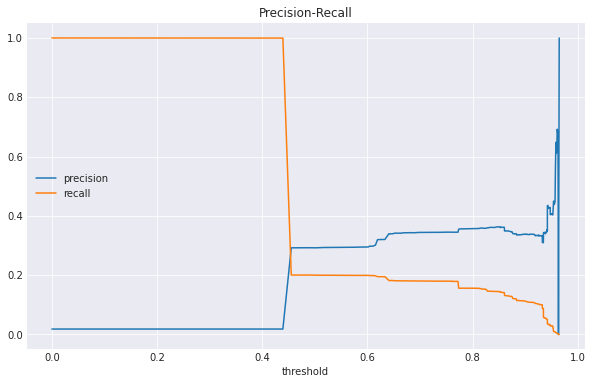

In [32]:
precision, recall, thresholds = precision_recall_curve(valid_target.target.values, valid_target.score.values)
thresholds = np.asarray([0.0] + thresholds.tolist())
#ax[2].figure(figsize=(6, 6))
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
plt.title('Precision-Recall')
plt.xlabel('threshold')
plt.legend(loc='best')
plt.show()

## Бета-калибровка

## Бета-калибровка каждого фолда на отложенных данных и усреднение предсказаний

In [33]:
def train_folds_1beta(X, X_sol, lgbm_params={}, early_stopping_rounds=10,
                verbose_eval=False, rounds=1000, meta_cls=False, sampling=False,
                importance_method='gain', calibration=True):

    X = X.reset_index()
    ts_values = sorted(list(set(X.last_day.values)))
    ts_values1 = copy.deepcopy(ts_values)
    ts_values = ts_values[len(ts_values)-min(conf.MAX_MODELS+conf.TRAIN_PERIODS, len(ts_values)):]
    ts_values_c = ts_values1[max(len(ts_values1)-min(conf.MAX_MODELS+conf.TRAIN_PERIODS, len(ts_values1))-3,0):]
    ts_folds = []
    ts_folds_c = []
    
    for n in range(conf.TRAIN_PERIODS, len(ts_values)):
        ts_folds.append((ts_values[max(0, n-conf.TRAIN_PERIODS):n], ts_values[n]))
    n_folds = len(ts_folds)
    print('Folds: {}'.format(n_folds))
    print(ts_folds)
# calibration
    if calibration:
        for n in range(conf.TRAIN_PERIODS, len(ts_values_c)):
            ts_folds_c.append(ts_values_c[max(0, n-conf.TRAIN_PERIODS):n])
        n_folds_c = len(ts_folds_c)
        print('Folds: {}'.format(n_folds_c))
        print(ts_folds_c)

        for i,j in zip(ts_folds,ts_folds_c):
            print(i,j)

    if calibration:
        X = X.loc[X.last_day.isin(ts_values+ts_values_c)].copy()
    else:
        X = X.loc[X.last_day.isin(ts_values)].copy()
        
    y_sol = X_sol['target']
    X_sol = X_sol.drop(['target'], 1)

    blend_sol = np.zeros((X_sol.shape[0], n_folds), dtype='float32')

    columns = X.drop(['target', 'inn', 'last_day'], 1, errors='ignore').columns.tolist()
    importances = pd.DataFrame([], index=columns)
    importances.index.name = 'feature'

    models = []
    raw_score = meta_cls
    ttrains, ttest = zip(*ts_folds)
    if calibration:
        
        fig1, ax1 = plt.subplots()
        ax1.plot([0, 1], [0, 1], 'k:')
        ax1.set_title('Calibration curve')

        for i, (train_values, test_value, cal_values) in enumerate(zip(ttrains, ttest, ts_folds_c)):
            print(test_value, train_values, cal_values)
            X_train = X.loc[X.last_day.isin(train_values)].copy()
            X_test = X.loc[X.last_day == test_value].copy()
            X_cal = X.loc[X.last_day.isin(cal_values)].copy()
            
            y_train = X_train['target'].copy()
            y_test = X_test['target'].copy()
            y_cal = X_cal['target'].copy()
            
            if sampling:
                X_train = random_downsampling(X_train)
                y_train = X_train['target'].copy()
                X_cal = random_downsampling(X_cal)
                y_cal = X_cal['target'].copy()


            X_train = X_train.drop(['target'], 1)
            X_test = X_test.drop(['target'], 1)
            X_cal = X_cal.drop(['target'], 1)
            
            X_train = X_train.set_index(['inn', 'last_day'])
            X_test = X_test.set_index(['inn', 'last_day'])
            X_cal = X_cal.set_index(['inn', 'last_day'])

            X_train, y_train = shuffle(X_train, y_train)
            X_cal, y_cal = shuffle(X_cal, y_cal)
            
            print('FOLD: train: {}, train pos/neg: {}/{}, balance: {:.3f}'
                  .format(str(X_train.shape), y_train.values.sum(),
                          y_train.size-y_train.values.sum(), y_train.values.mean()))
            print('FOLD: test: {}, test pos/neg: {}/{}, balance: {:.3f}'
                  .format(str(X_test.shape), y_test.values.sum(),
                          y_test.size-y_test.values.sum(), y_test.values.mean()))
            print('FOLD: calibration: {}, test pos/neg: {}/{}, balance: {:.3f}'
                  .format(str(X_cal.shape), y_cal.values.sum(),
                          y_cal.size-y_cal.values.sum(), y_cal.values.mean()))
            
            
            lgbm_train = lgbm.Dataset(X_train, y_train)
            lgbm_test = lgbm.Dataset(X_test, y_test, reference=lgbm_train)

            assert (X_train.shape[1] == X_test.shape[1]) and (X_train.columns == X_test.columns).all()
            assert (X_train.shape[1] == X_sol.shape[1]) and (X_train.columns == X_sol.columns).all()

            model = lgbm.train(lgbm_params,
                               lgbm_train,
                               num_boost_round = rounds,
                               valid_sets = [lgbm_train, lgbm_test],
                               valid_names = ['train', 'valid'],
                               verbose_eval = verbose_eval,
                               early_stopping_rounds = early_stopping_rounds)
#             model = lgbm.LGBMClassifier(**lgbm_params, 
#                                         verbose_eval = verbose_eval).fit(X_train, y_train)


#             cal_model = CalibratedClassifierCV(base_estimator=model, cv='prefit', method='isotonic')
#             cal_model.fit(X_cal, y_cal)
            trees = model.best_iteration
# 
            train_proba = model.predict(X_train)
            cal_proba = model.predict(X_cal)
            
            bc = BetaCalibration(parameters='abm')
            bc.fit(cal_proba, y_cal)
            
            model_file = '{}/model_cv_{:02d}.txt'.format(model_path, i)
            cal_file = '{}/model_cv_{:02d}.pkl'.format(model_path, i)
            model.save_model(model_file)
            with open(cal_file, 'wb') as mf:
                pickle.dump(bc, mf)
            models.append((model_file, cal_file))
            
            
#             model_file = '{}/model_cv_{:02d}.txt'.format(model_path, i)
#             model_cal.save_model(model_file)
            
            test_proba = model.predict(X_test)
            sol_proba = model.predict(X_sol)
            
            test_proba_cal = bc.predict(test_proba)
            sol_proba_cal = bc.predict(sol_proba)


            train_auc = roc_auc_score(y_train, train_proba)
            test_auc = roc_auc_score(y_test, test_proba)
            sol_auc = roc_auc_score(y_sol, sol_proba)
            
            test_auc_cal = roc_auc_score(y_test, test_proba_cal)
            sol_auc_cal = roc_auc_score(y_sol, sol_proba_cal)           

            print('{:2} TRAIN:{:.5f} TEST:{:.5f} SOL:{:.5f} TREES:{:6} min-max:[{:.4f}...{:.4f}] avg:{:.4f}'.format(
                    i, train_auc, test_auc, sol_auc, trees, test_proba.min(), test_proba.max(), test_proba.mean() ))
            
            print('TEST: AUC = {:.3f} vs AUC_cal = {:.3f}\nSOL: AUC = {:.3f} vs AUC_cal = {:.3f}'
                  .format(test_auc, test_auc_cal, sol_auc, sol_auc_cal)
                 )

            x1, y1 = calibration_curve(y_sol, sol_proba_cal, n_bins=10, normalize=True)
            ax1.plot(y1, x1, label='period {}: {}'.format(i, test_value))


#             importances['fold_%d' % i] = model.feature_importances_()
            blend_sol[:,i] = sol_proba
            print('-' * 100)
#             if i == 0: break

        print('-' * 100)
        sol = blend_sol.mean(axis=1)

        if meta_cls:
            print('Train meta model')
            if y_sol is not None:
                print('Avg concat:')
                print(get_report(y_sol, sol, threshold=0.5))
                print('-' * 100)

            X = X.set_index(['inn', 'last_day'])
            y = X['target'].copy()
            X = X.drop(['target'], 1)
            blend_train = np.zeros((X.shape[0], len(models)), dtype='float32')
            blend_sol = np.zeros((X_sol.shape[0], len(models)), dtype='float32')
            print('Meta train shapes: {}, {}'.format(str(blend_train.shape), str(blend_sol.shape)))

            for i, (model_file, cal_file) in enumerate(models):
                model = lgbm.Booster(model_file=model_file, silent=True)
                with open(cal_file, 'rb') as mf:
                    bc = pickle.load(mf)

                train_proba = model.predict(X)
                train_proba_cal = bc.predict(train_proba)
                blend_train[:, i] = train_proba_cal

                sol_proba = model.predict(X_sol)
                sol_proba_cal = bc.predict(sol_proba)
                blend_sol[:, i] = sol_proba_cal

            # np.save('{}/train_output_raw.npy'.format(data_path), blend_train)
            # np.save('{}/test_output_raw.npy'.format(data_path), blend_sol)
            # np.save('{}/train_target_raw.npy'.format(data_path), y.values)
            # np.save('{}/test_target_raw.npy'.format(data_path), y_sol)

#             lr = LogisticRegression(class_weight='balanced', C=conf.LOGREG_C)
#             lr.fit(blend_train, y.values)
#             sol = lr.predict_proba(blend_sol)[:,1]
#             print(lr.coef_, lr.intercept_)

            sol = np.mean(blend_sol, axis=1)
            
            x, y = calibration_curve(valid_target.target, sol, n_bins=10, normalize=True)
            ax1.plot(y, x, label='meta', color='k')
            ax1.legend()
            ax1.set_title('Бета-Калибровка каждого фолда на отложенных данных')
            plt.savefig('beta_cal_mean.png')            

        return sol #, importances

Folds: 12
[(['2019-10-31', '2019-11-30', '2019-12-31'], '2020-01-31'), (['2019-11-30', '2019-12-31', '2020-01-31'], '2020-02-29'), (['2019-12-31', '2020-01-31', '2020-02-29'], '2020-03-31'), (['2020-01-31', '2020-02-29', '2020-03-31'], '2020-04-30'), (['2020-02-29', '2020-03-31', '2020-04-30'], '2020-05-31'), (['2020-03-31', '2020-04-30', '2020-05-31'], '2020-06-30'), (['2020-04-30', '2020-05-31', '2020-06-30'], '2020-07-31'), (['2020-05-31', '2020-06-30', '2020-07-31'], '2020-08-31'), (['2020-06-30', '2020-07-31', '2020-08-31'], '2020-09-30'), (['2020-07-31', '2020-08-31', '2020-09-30'], '2020-10-31'), (['2020-08-31', '2020-09-30', '2020-10-31'], '2020-11-30'), (['2020-09-30', '2020-10-31', '2020-11-30'], '2020-12-31')]
Folds: 12
[['2019-10-31', '2019-11-30', '2019-12-31'], ['2019-11-30', '2019-12-31', '2020-01-31'], ['2019-12-31', '2020-01-31', '2020-02-29'], ['2020-01-31', '2020-02-29', '2020-03-31'], ['2020-02-29', '2020-03-31', '2020-04-30'], ['2020-03-31', '2020-04-30', '2020-05-

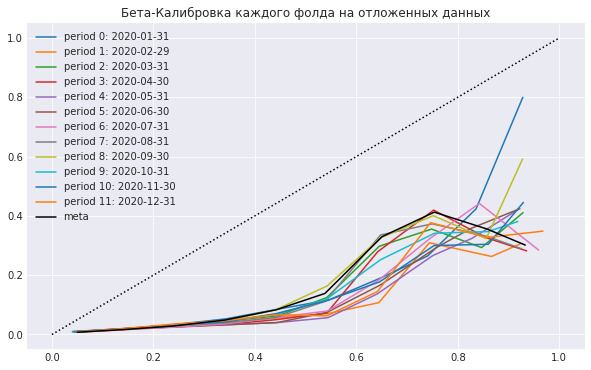

In [34]:
valids = train_folds_1beta(train, valid,
                                  lgbm_params=lgbm_params,
                                  **params)


valid_target['score'] = valids
print(get_report(valid_target.target.values, valids, threshold=0.5))

# valid_file = '{}/valids.csv'.format(data_path)
# importances_file = '{}/importances_{}.csv'.format(data_path, conf.IMPORTANCE_METHOD)
# valid_target.to_csv(valid_file)
# importances.to_csv(importances_file)
# print('Validation data file: {}'.format(valid_file))
# print('Importances file: {}'.format(importances_file))

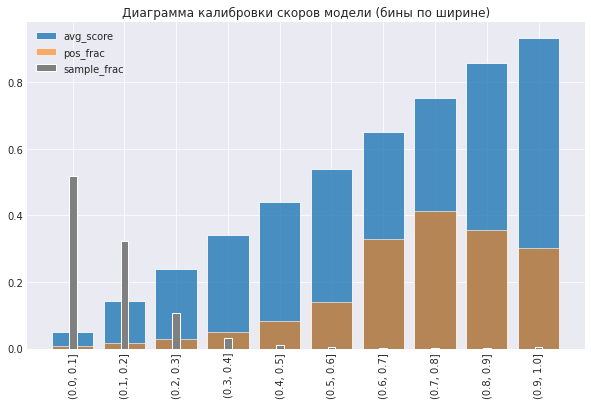

,pos_frac,avg_score,sample_frac
bin,,,
"(0.0, 0.1]",0.007542,0.050033,0.518080
"(0.1, 0.2]",0.016662,0.142270,0.321765
"(0.2, 0.3]",0.028520,0.239575,0.105480
"(0.3, 0.4]",0.048662,0.340998,0.030910
"(0.4, 0.5]",0.083121,0.441685,0.011245
"(0.5, 0.6]",0.138378,0.538218,0.003313
"(0.6, 0.7]",0.329787,0.650727,0.001347
"(0.7, 0.8]",0.412500,0.753739,0.001719
"(0.8, 0.9]",0.355499,0.857918,0.002801


In [35]:
calibration_plot(valid_target, bins=10)

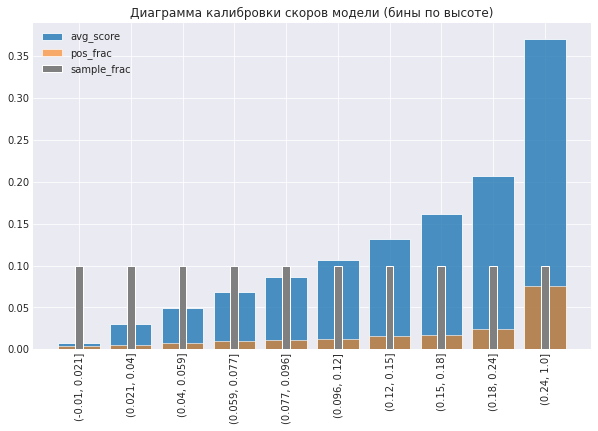

,pos_frac,avg_score,sample_frac
bin,,,
"(-0.01, 0.021]",0.004298,0.007181,0.100000
"(0.021, 0.04]",0.004763,0.030599,0.100000
"(0.04, 0.059]",0.007198,0.049353,0.100000
"(0.059, 0.077]",0.009634,0.067830,0.100000
"(0.077, 0.096]",0.011102,0.086509,0.100000
"(0.096, 0.12]",0.012786,0.106970,0.099997
"(0.12, 0.15]",0.016223,0.131235,0.100000
"(0.15, 0.18]",0.017656,0.161669,0.100000
"(0.18, 0.24]",0.024030,0.207343,0.100000


In [36]:
calibration_plot(valid_target, bins=10, quantile=True)

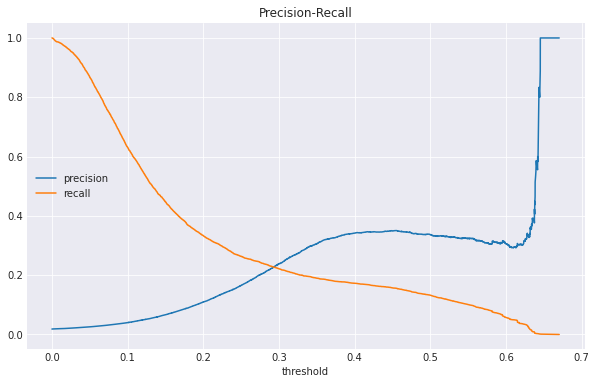

In [37]:
precision, recall, thresholds = precision_recall_curve(valid_target.target.values, valid_target.score.values)
thresholds = np.asarray([0.0] + thresholds.tolist())
#ax[2].figure(figsize=(6, 6))
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
plt.title('Precision-Recall')
plt.xlabel('threshold')
plt.legend(loc='best')
plt.show()

In [40]:
periods = train.groupby('last_day').count().shape[0]

In [42]:
conf.MAX_MODELS = int(periods / 2)
print(periods, conf.MAX_MODELS)

15 7


In [50]:
conf.MAX_MODELS = 6

## Калибровка метамодели на отложенных фолдах

In [51]:
def train_folds_2(X, X_sol, lgbm_params={}, early_stopping_rounds=10,
                verbose_eval=False, rounds=1000, meta_cls=False, sampling=False,
                importance_method='gain', n_cal_folds = conf.MAX_MODELS):

    X = X.reset_index()
    ts_values = sorted(list(set(X.last_day.values)))
    ts_values = ts_values[len(ts_values)-min(conf.MAX_MODELS+conf.TRAIN_PERIODS+n_cal_folds, len(ts_values)):]    
    ts_folds = []

    
    for n in range(conf.TRAIN_PERIODS, len(ts_values)):
        ts_folds.append((ts_values[max(0, n-conf.TRAIN_PERIODS):n], ts_values[n]))
    n_folds = len(ts_folds)
    print('Folds: {}'.format(n_folds))
    print(ts_folds)

    X = X.loc[X.last_day.isin(ts_values)].copy()
        
    y_sol = X_sol['target']
    X_sol = X_sol.drop(['target'], 1)

    blend_sol = np.zeros((X_sol.shape[0], n_folds), dtype='float32')

    columns = X.drop(['target', 'inn', 'last_day'], 1, errors='ignore').columns.tolist()
    importances = pd.DataFrame([], index=columns)
    importances.index.name = 'feature'

#     model_path = os.path.abspath('../models/{}'.format(conf.MODEL_NAME))
#     data_path = os.path.abspath('../data/{}'.format(conf.MODEL_NAME))

    models = []
    raw_score = meta_cls
    
    fig1, ax1 = plt.subplots()
    ax1.plot([0, 1], [0, 1], 'k:')
    ax1.set_title('Calibration curve')


    for i, (train_values, test_value) in enumerate(ts_folds):
        print(test_value, train_values)
        X_train = X.loc[X.last_day.isin(train_values)].copy()
        X_test = X.loc[X.last_day == test_value].copy()
        
        y_train = X_train['target'].copy()
        y_test = X_test['target'].copy()
        
        if sampling:
            X_train = random_downsampling(X_train)
            y_train = X_train['target'].copy()
        
        X_train = X_train.drop(['target'], 1)
        X_test = X_test.drop(['target'], 1)

        X_train = X_train.set_index(['inn', 'last_day'])
        X_test = X_test.set_index(['inn', 'last_day'])

        X_train, y_train = shuffle(X_train, y_train)

        print('FOLD: train: {}, train pos/neg: {}/{}, balance: {:.3f}'
              .format(str(X_train.shape), y_train.values.sum(),
                      y_train.size-y_train.values.sum(), y_train.values.mean()))
        print('FOLD: test: {}, test pos/neg: {}/{}, balance: {:.3f}'
              .format(str(X_test.shape), y_test.values.sum(),
                      y_test.size-y_test.values.sum(), y_test.values.mean()))

        lgbm_train = lgbm.Dataset(X_train, y_train)
        lgbm_test = lgbm.Dataset(X_test, y_test, reference=lgbm_train)

        assert (X_train.shape[1] == X_test.shape[1]) and (X_train.columns == X_test.columns).all()
        assert (X_train.shape[1] == X_sol.shape[1]) and (X_train.columns == X_sol.columns).all()

        model = lgbm.train(lgbm_params,
                           lgbm_train,
                           num_boost_round = rounds,
                           valid_sets = [lgbm_train, lgbm_test],
                           valid_names = ['train', 'valid'],
                           verbose_eval = verbose_eval,
                           early_stopping_rounds = early_stopping_rounds)
#         model = lgbm.LGBMClassifier(**lgbm_params, 
#                                     verbose_eval = verbose_eval).fit(X_train, y_train)


        trees = model.best_iteration
        model_file = '{}/model_cv_{:02d}.txt'.format(model_path, i)
#        model_file = '{}/model_cv_{:02d}.pkl'.format(model_path, i)
        model.save_model(model_file)
#         with open(model_file, 'wb') as mf:
#             pickle.dump(model, mf)
        models.append(model_file)

        train_proba = model.predict(X_train)
        test_proba = model.predict(X_test)
        sol_proba = model.predict(X_sol)

        train_auc = roc_auc_score(y_train, train_proba)
        test_auc = roc_auc_score(y_test, test_proba)
        sol_auc = roc_auc_score(y_sol, sol_proba)

        print('{:2} TRAIN:{:.5f} TEST:{:.5f} SOL:{:.5f} TREES:{:6} min-max:[{:.4f}...{:.4f}] avg:{:.4f}'.format(
                i, train_auc, test_auc, sol_auc, trees, test_proba.min(), test_proba.max(), test_proba.mean() ))
        
        x1, y1 = calibration_curve(y_sol, sol_proba, n_bins=10, normalize=True)
        ax1.plot(y1, x1, label='period {}: {}'.format(i, test_value))


#             importances['fold_%d' % i] = model.feature_importances_()
        blend_sol[:,i] = sol_proba
        print('-' * 100)
#         if i == 2: break

    print('-' * 100)
    sol = blend_sol.mean(axis=1)

    if meta_cls:
        print('Train meta model')
        if y_sol is not None:
            print('Avg concat:')
            print(get_report(y_sol, sol, threshold=0.5))
            print('-' * 100)

        
        X_cal = X[X.last_day.isin(ts_values[:n_cal_folds])].set_index(['inn', 'last_day']).copy()
        y_cal = X_cal['target'].copy()
        X_cal = X_cal.drop(['target'], 1)
        
        print('Calibration shapes: X - {}, y - {}'.format(X_cal.shape, y_cal.shape))
        
        X = X[X.last_day.isin(ts_values[n_cal_folds:])].set_index(['inn', 'last_day'])
        y = X['target'].copy()
        X = X.drop(['target'], 1)
        
        print('Train shapes: X - {}, y - {}'.format(X.shape, y.shape))
                
        models_cal = models[:n_cal_folds]
        models = models[n_cal_folds:]
        
        blend_train = np.zeros((X.shape[0], len(models)), dtype='float32')
        blend_sol = np.zeros((X_sol.shape[0], len(models)), dtype='float32')
        
        # for calibration
        blend_train_cal = np.zeros((X_cal.shape[0], len(models_cal)), dtype='float32')
        blend_sol_cal = np.zeros((X_sol.shape[0], len(models_cal)), dtype='float32')

        
        print('Meta train shapes: {}, {}'.format(str(blend_train.shape), str(blend_sol.shape)))

        for i, model_file in enumerate(models_cal):
            model = lgbm.Booster(model_file=model_file, silent=True)
#             with open(model_file, 'rb') as mf:
#                 model = pickle.load(mf)

            train_proba = model.predict(X_cal)
            blend_train_cal[:, i] = train_proba

#             sol_proba = model.predict(X_sol)
#             blend_sol_cal[:, i] = sol_proba
            
        for i, model_file in enumerate(models):
            model = lgbm.Booster(model_file=model_file, silent=True)
#             with open(model_file, 'rb') as mf:
#                 model = pickle.load(mf)

            train_proba = model.predict(X)
            blend_train[:, i] = train_proba

            sol_proba = model.predict(X_sol)
            blend_sol[:, i] = sol_proba
            

        # np.save('{}/train_output_raw.npy'.format(data_path), blend_train)
        # np.save('{}/test_output_raw.npy'.format(data_path), blend_sol)
        # np.save('{}/train_target_raw.npy'.format(data_path), y.values)
        # np.save('{}/test_target_raw.npy'.format(data_path), y_sol)

        lr = LogisticRegression(class_weight='balanced', C=conf.LOGREG_C)
        lr.fit(blend_train, y.values)
        
                
        cf = CalibratedClassifierCV(base_estimator=lr, cv='prefit', method='isotonic')
        cf.fit(blend_train_cal, y_cal.values)
 
        
        sol = cf.predict_proba(blend_sol)[:,1]
        
        x, y = calibration_curve(valid_target.target, sol, n_bins=10, normalize=True)
        ax1.plot(y, x, label='meta', color='k')
        ax1.legend()
        ax1.set_title('Калибровка метамодели на отложенных данных изотонической регрессией')
        plt.savefig('meta_cal_iso.png')        

#         print(lr.coef_, lr.intercept_)

    return sol #, importances

Folds: 12
[(['2019-10-31', '2019-11-30', '2019-12-31'], '2020-01-31'), (['2019-11-30', '2019-12-31', '2020-01-31'], '2020-02-29'), (['2019-12-31', '2020-01-31', '2020-02-29'], '2020-03-31'), (['2020-01-31', '2020-02-29', '2020-03-31'], '2020-04-30'), (['2020-02-29', '2020-03-31', '2020-04-30'], '2020-05-31'), (['2020-03-31', '2020-04-30', '2020-05-31'], '2020-06-30'), (['2020-04-30', '2020-05-31', '2020-06-30'], '2020-07-31'), (['2020-05-31', '2020-06-30', '2020-07-31'], '2020-08-31'), (['2020-06-30', '2020-07-31', '2020-08-31'], '2020-09-30'), (['2020-07-31', '2020-08-31', '2020-09-30'], '2020-10-31'), (['2020-08-31', '2020-09-30', '2020-10-31'], '2020-11-30'), (['2020-09-30', '2020-10-31', '2020-11-30'], '2020-12-31')]
2020-01-31 ['2019-10-31', '2019-11-30', '2019-12-31']
FOLD: train: (192400, 72), train pos/neg: 19240/173160, balance: 0.100
FOLD: test: (255726, 72), test pos/neg: 6235/249491, balance: 0.024
 0 TRAIN:0.77204 TEST:0.75195 SOL:0.72485 TREES:   389 min-max:[0.0292...0.9

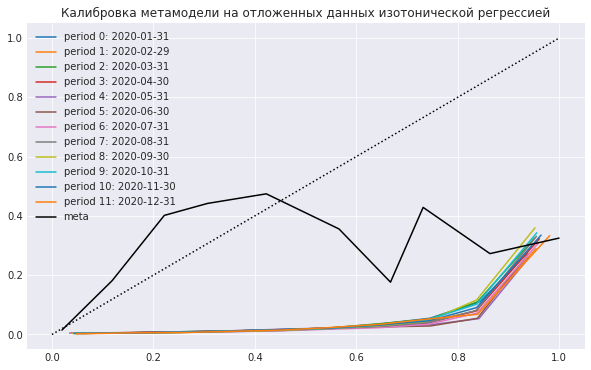

In [52]:
valids = train_folds_2(train, valid,
                                  lgbm_params=lgbm_params,
                                  **params)


valid_target['score'] = valids
print(get_report(valid_target.target.values, valids, threshold=0.5))

# valid_file = '{}/valids.csv'.format(data_path)
# importances_file = '{}/importances_{}.csv'.format(data_path, conf.IMPORTANCE_METHOD)
# valid_target.to_csv(valid_file)
# importances.to_csv(importances_file)
# print('Validation data file: {}'.format(valid_file))
# print('Importances file: {}'.format(importances_file))

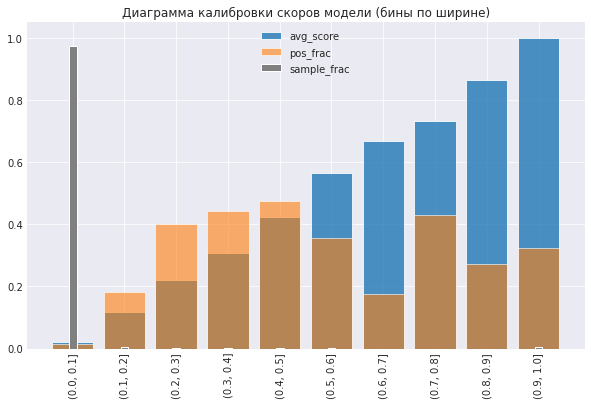

,pos_frac,avg_score,sample_frac
bin,,,
"(0.0, 0.1]",0.015054,0.020063,0.972277
"(0.1, 0.2]",0.181407,0.118630,0.005547
"(0.2, 0.3]",0.401596,0.221508,0.001347
"(0.3, 0.4]",0.441948,0.306585,0.000956
"(0.4, 0.5]",0.474359,0.422558,0.000279
"(0.5, 0.6]",0.355932,0.565874,0.000845
"(0.6, 0.7]",0.176471,0.667398,0.000122
"(0.7, 0.8]",0.428571,0.731762,0.000025
"(0.8, 0.9]",0.272727,0.863471,0.000158


In [54]:
calibration_plot(valid_target, bins=10)

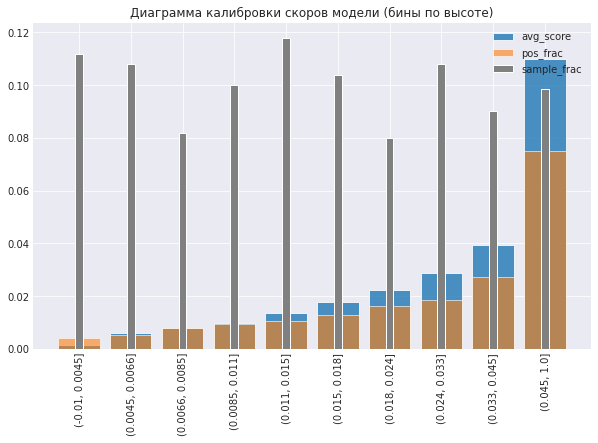

,pos_frac,avg_score,sample_frac
bin,,,
"(-0.01, 0.0045]",0.004223,0.001647,0.111948
"(0.0045, 0.0066]",0.005236,0.006124,0.108058
"(0.0066, 0.0085]",0.007851,0.007953,0.081657
"(0.0085, 0.011]",0.009297,0.009951,0.100158
"(0.011, 0.015]",0.010494,0.013578,0.117735
"(0.015, 0.018]",0.012850,0.017801,0.103675
"(0.018, 0.024]",0.016240,0.022248,0.080049
"(0.024, 0.033]",0.018683,0.028613,0.107919
"(0.033, 0.045]",0.027168,0.039408,0.090166


In [55]:
calibration_plot(valid_target, bins=10, quantile=True)

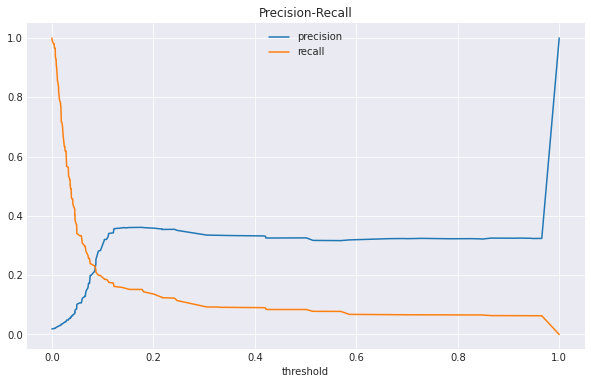

In [56]:
precision, recall, thresholds = precision_recall_curve(valid_target.target.values, valid_target.score.values)
thresholds = np.asarray([0.0] + thresholds.tolist())
#ax[2].figure(figsize=(6, 6))
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
plt.title('Precision-Recall')
plt.xlabel('threshold')
plt.legend(loc='best')
plt.show()